# Example for Quantum Amplitude Estimation
In this notebooks we show how the Quantum Amplitude Estimation (QAE) algorithm can be implemented with geqo. The algorithm is described in G. Brassard, P. Hoyer, M. Mosca, A. Tapp, "Quantum Amplitude Amplification and Estimation", Quantum Computation and Quantum Information, Samuel J. Lomonaco, Jr. (editor), AMS Contemporary Mathematics, 305:53-74, 2002. A version of this article can be found under [arXiv:quant-ph/0005055](https://arxiv.org/abs/quant-ph/0005055).

We consider a simple ```Ry``` rotation gate as quantum circuit for the QAE. For a given probability ```prob```, an rotation angle for the rotation is calculated. 

In [1]:
from geqo.core.quantum_circuit import Sequence
from geqo.gates import Ry
import math

prob = 0.75
aValue = 2 * math.asin(math.sqrt(prob))

seq = Sequence(["0"], [], [(Ry("a"), ["0"], [])])

Then the state $|1\rangle$ is measured with the specified probability after applying this gate to an initialized system. This can be seen by the density matrix of the system. The density matrix can be obtained with the simulator ```ensembleSimulatorSymPy``` as follows.

In [2]:
from geqo.simulators import ensembleSimulatorSymPy

sim = ensembleSimulatorSymPy(1, 0)
sim.setValue("a", aValue)
sim.apply(seq, [0])
display(sim.ensemble[()][1])

Matrix([
[             0.25, 0.433012701892219],
[0.433012701892219,              0.75]])

For the QAE, we construct the Grover operator $G=-R_Y(a) S_0 R_Y(-a) S_x$, where $S_0$ and $S_x$ are phase operations. More precisely, $S_0$ multiplies the state $|0\rangle$ with the phase $-1$ and all other states with the trivial phase $1$. In a similar way, $S_x$ marks all states with $-1$, for which we search the corresponding probability. In our example, this is the state $|1\rangle$.  

In [3]:
from geqo.gates import PauliX, PauliZ

# Build the Grover operator
grov = Sequence(
    ["q0"],
    [],
    [
        (PauliZ(), ["q0"], []),  # Mark the state 1 with phase -1.
        (
            seq.getInverse(),
            ["q0"],
            [],
        ),  # the inverse operation is a rotation with angle -a
        (PauliX(), ["q0"], []),  # These 4 gates implement a global -1 phase.
        (PauliZ(), ["q0"], []),
        (PauliX(), ["q0"], []),
        (PauliZ(), ["q0"], []),
        (PauliX(), ["q0"], []),  # Mark the state 0 with phase -1.
        (PauliZ(), ["q0"], []),
        (PauliX(), ["q0"], []),
        (seq, ["q0"], []),
    ],  # the rotation with angle a
)

We want to estimate the probability of the state $|1\rangle$ with $4$ bits precision. For this, we need the powers $G, G^2, G^4$ and $G^8$ of the Grover operator. These are defined with the following statements along with the QFT, which we need on the output register of 4 qubits of the QAE.

In [4]:
from geqo.algorithms import InverseQFT

pow1 = Sequence(["q0"], [], [(grov, ["q0"], [])])
pow2 = Sequence(["q0"], [], [(pow1, ["q0"], []), (pow1, ["q0"], [])])
pow4 = Sequence(["q0"], [], [(pow2, ["q0"], []), (pow2, ["q0"], [])])
pow8 = Sequence(["q0"], [], [(pow4, ["q0"], []), (pow4, ["q0"], [])])
qft = InverseQFT(4)

With the defined sequences, we can create the full circuit for the QAE. The powers of the Grover oracle are each controlled by a qubit in superposition.

In [5]:
from geqo.gates import Hadamard
from geqo.operations import QuantumControl

gatesAndTargets = []
gatesAndTargets.append((Hadamard(), ["p0"], []))
gatesAndTargets.append((Hadamard(), ["p1"], []))
gatesAndTargets.append((Hadamard(), ["p2"], []))
gatesAndTargets.append((Hadamard(), ["p3"], []))
gatesAndTargets.append((seq, ["q0"], []))
gatesAndTargets.append((QuantumControl([1], pow8), ["p0", "q0"], []))
gatesAndTargets.append((QuantumControl([1], pow4), ["p1", "q0"], []))
gatesAndTargets.append((QuantumControl([1], pow2), ["p2", "q0"], []))
gatesAndTargets.append((QuantumControl([1], pow1), ["p3", "q0"], []))
gatesAndTargets.append((qft, ["p0", "p1", "p2", "p3"], []))
seq2 = Sequence(["p0", "p1", "p2", "p3", "q0"], [], gatesAndTargets)

The output of the QAE is an estimation of the probability in binary format. We define the function, which calculates the probability values corresponding to the binary outputs.

In [6]:
from geqo.utils import bin2num


def bit2prob(bits):
    summe = bin2num(bits)
    res = summe / 2 ** (len(bits) - 1)
    theta_estim = math.pi * res / 2.0
    prob_estim = math.sin(theta_estim) * math.sin(theta_estim)
    return prob_estim

The probability values corresponding to the possible binary results are not evenly distributed in the intervall $[0,1]$. The following values and the plot shows that the values are denser around $0$ and $1$ in contrast to $0.5$. 

(0, 0, 0, 0) 0.0
(0, 0, 0, 1) 0.03806023374435662
(0, 0, 1, 0) 0.14644660940672624
(0, 0, 1, 1) 0.3086582838174551
(0, 1, 0, 0) 0.4999999999999999
(0, 1, 0, 1) 0.6913417161825449
(0, 1, 1, 0) 0.8535533905932737
(0, 1, 1, 1) 0.9619397662556434
(1, 0, 0, 0) 1.0
(1, 0, 0, 1) 0.9619397662556434
(1, 0, 1, 0) 0.8535533905932737
(1, 0, 1, 1) 0.6913417161825453
(1, 1, 0, 0) 0.5000000000000001
(1, 1, 0, 1) 0.3086582838174551
(1, 1, 1, 0) 0.14644660940672632
(1, 1, 1, 1) 0.038060233744356756


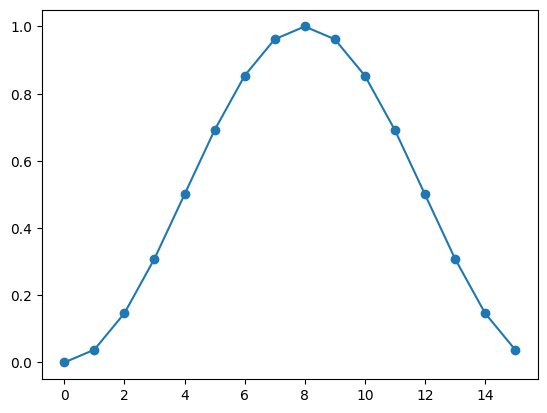

In [7]:
import itertools
import matplotlib.pyplot as plt

xe2 = []
ye2 = []
for i in itertools.product([0, 1], repeat=4):
    print(i, bit2prob(i))
    xe2.append(bin2num(i))
    ye2.append(bit2prob(i))
plt.scatter(xe2, ye2)
plt.plot(xe2, ye2)

We run the QAE algorithm of the given quantum circuit on the ensemble simulator. At the end, a measurement of the 4 output qubits is performed on the system.

In [8]:
from geqo.operations import Measure

sim = ensembleSimulatorSymPy(5, 4)
sim.setValue("a", aValue)
sim.prepareBackend([qft])

sim.apply(seq2, [0, 1, 2, 3, 4], [])
sim.apply(Measure(4), [0, 1, 2, 3], [0, 1, 2, 3])

We collect all possible measurement results from the ensemble along with their probabilities. Since for most possible probability values there are two possible binary representation, we round the values to 5 digits and sum up the probabilities of equal solutions.

In [9]:
te = {}
for e in sim.ensemble:
    estim = round(bit2prob(e), 5)
    prob = sim.ensemble[e][0].evalf()
    if estim in te:
        te[estim] += prob
    else:
        te[estim] = prob

In [10]:
xe = []
ye = []
for t in te:
    xe.append(t)
    ye.append(te[t])
for t in te:
    print(t, ":", te[t])

0.0 : 0.00390624999999999
0.03806 : 0.00845014719874149
0.14645 : 0.0108859240797014
0.30866 : 0.0179187491022236
0.5 : 0.0468750000000000
0.69134 : 0.688537554578972
0.85355 : 0.176614075920298
0.96194 : 0.0350935491200642
1.0 : 0.0117187500000000


The results show that the output of the QAE which corresponds to $0.69134$ and $0.85355$ have together a probability of $86.5\%$. Both solutions are the closest approximations to the real solution $0.75$.

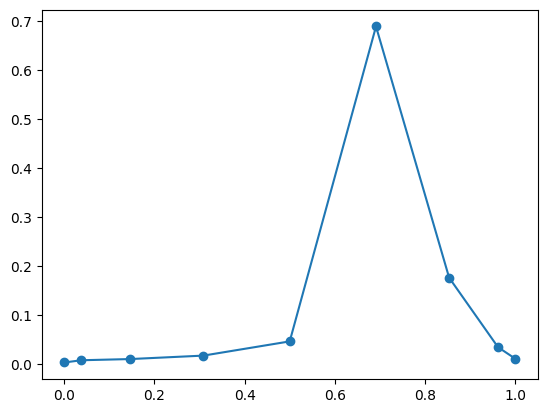

In [11]:
import matplotlib.pyplot as plt

plt.plot(xe, ye)
plt.scatter(xe, ye)